In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform
import seaborn as sns
import matplotlib
import vegas
import functools

from utils import alphas, particle, vector, shower

matplotlib.rcParams.update({'font.size': 17})
sns.set_style("white")


# To do:

- make a side by side comparisson of the errors of all three methods
- revise code comments
- fix the hisrogram
- make sure to put in the units for allgraphs
- check that the arccostheta thing inthe parton shower is ok


** posible errors**

the calcualtion of alpha as a fixed dependence on mz

the random choosing of quarks outside the montecalro

In [2]:
def Vf(Tf3, Qf):
    # calculates vector coupling for the f quark
    # args-> Tf3: scalar, weak isosipin of f quark.
    #        Qf: scalar, charge of f quark
    # returns vf: scalar, vector copuling
    
    return Tf3 - 2*Qf*sin2w

def Af(Tf3):
    # calculates axial coupling for the f quark
    # args-> Tf3: scalar, weak isosipin of f quark.
    # returns af: scalar, vector copuling
    
    return Tf3

def Chi1(s_var):
    # calculates chi1 as a function of s
    # args -> s_var: array or scalar, for the s variable
    return k*s_var*(s_var-Mz**2)/( (s_var-Mz**2)**2 + Gammaz**2*Mz**2 )
    
def Chi2(s_var):
    # calculates chi1 as a function of s
    # args -> s_var: array or scalar, for the s variable
    return (k**2)*(s_var**2)/( (s_var-Mz**2)**2 + Gammaz**2*Mz**2)

def initialize_quark_sequence(N_steps):
    # cdraw random quark flavors for each montecarlo step and calculate their quantities
    
    # randomly generate the indices
    flavor_indices = np.random.randint(0,Nq, size=N_steps)

    # calculate the values for each step
    charge_sequence = np.asarray([quark_charges[x] for x in flavor_indices])
    isospin_sequence = np.asarray([quark_isospin[x] for x in flavor_indices])
    Aq_array = Af(isospin_sequence)
    Vq_array = Vf(isospin_sequence, charge_sequence)
    
    return charge_sequence, Aq_array, Vq_array
    

def init_montecarlo(N_steps,s0, s_constant=True):
    # generates the events for the montecarlo
    # args -> N_steps: int, number of steps in the montecarlo
    #        s0: float, value of s for the fixed case
    #        s_constant: Boolean, indicates whether to use uniform or fixed s
    
    # randomly generate the indices  
    charge_sequence, Aq_array, Vq_array = initialize_quark_sequence(N_steps)

    # draw random numbers for the integration
    if s_constant==True:
        s_var = s0
        fs = 1.0
    else:
        # choose s as an uniformly distributed variable
        s_upper = (Mz + 3*Gammaz)**2 
        s_lower = (Mz - 3*Gammaz)**2 
        s_var = np.random.uniform(low=s_lower, high=s_upper, size=(N_steps))
        fs = 1.0/(s_upper-s_lower)
        
    costh = np.random.uniform(low=-1, high=1, size=(N_steps))
    phi = np.random.uniform(low=0, high=2*np.pi, size=(N_steps))

    return s_var, fs, costh, phi, Aq_array, Vq_array, charge_sequence


def diff_cross_section(s_var, costh, fs, Qq ,Aq, Vq):
    # evaluates the differential cross section at the given points
    # args-> s: array/scalar, random numbers for the s varialbe
    #        costh: array/scalar, random numbers following a cos distribution
    #        phi:   array/sacalar, random numbers for the angle phi
    #        fs: array/scalar, disribution of s
    #        Qq, Aq, Vq: array, Charges and vector couplings for each of the generated events
    # returns-> array: the differential cross section evaluated on the given points
    
    return (fs/(s_var*64.0*np.pi**2)) * ( (4*np.pi*alpha)**2*Nc*( (1+costh**2)*(Qe**2*Qq**2 \
                   + 2*Qe*Qq*Ve*Vq*Chi1(s_var) + (Ae**2+Ve**2)*(Aq**2 + Vq**2)*Chi2(s_var))\
                   + costh*( 4*Qe*Qq*Ae*Aq*Chi1(s_var) + 8*Ae*Ve*Aq*Vq*Chi2(s_var) ) ) )

def montecarlo_cross_section(N_steps, benchmark_value, s0, constant_s=True):
    # Integrates the cross section using a simple montecarlo technique
    # args-> N_steps: integer, number of steps for the montecarlo
    #        benchmark_value: float, reference value to compare the result to
    #        s0: float: the value of s to be used for the fixed s case (constant_s=True)
    #        constant_s: boolean, indicaes whether to draw s from a uniform distribution or fix it
    # returns: sigma_eval, array containing the differential cross section evaluated at each step
    #          sigma_res: float, total cross section,  montecarlo_uncertainty: float, uncertainty in the montecarlo
    #          error: float representing the deviation from the benchmark value
    #          s: float/ array the s points evaluated
    
    # initialize the values
    s, fs, costh, phi, Aq_array, Vq_array, charge_sequence = init_montecarlo(N_steps,s0,constant_s)
    
    if constant_s==True:
        # integration interval for cos(theta)
        volume_interval = 2.0
    else:
        volume_interval = 2.0 * ((Mz + 3*Gammaz)**2 - (Mz - 3*Gammaz)**2)
    # value of the integral for phi
    phi_integral = 2.0*np.pi

    # calculate the cross section at several points
    sigma_eval = diff_cross_section(s, costh, fs, 
                       charge_sequence ,Aq_array, Vq_array)

    # perform the integral estimate
    sigma_res = Nq*phi_integral*volume_interval*(np.mean(sigma_eval))*F_conv

    # calculate the uncertainty
    montecarlo_uncertainty = 2 * np.sqrt( (np.mean(sigma_eval**2) - np.mean(sigma_eval)**2) 
                                     /float(N_steps))*F_conv*Nq*phi_integral*volume_interval
    
    return sigma_eval, sigma_res, montecarlo_uncertainty, np.abs(sigma_res-benchmark_value), s
                          

In [3]:
#INITIALIZE CONSTANTS

# qed coupling
alpha = 1.0/129.0
# Z boson mass
Mz = 91.2
# Z decay width
Gammaz = 2.5
# qcd colors
Nc = 3.0
# qcd light quark flavors
Nq = 5.0
# electric charge of electron
Qe = -1.0
# electric charge of light up type quarks
Qu = 2.0/3.0
# electric charge of down quarks
Qd = -1.0/3.0
# weinberg angle function
sin2w = 0.223
# prefactor for chi functions
k = 1/(4.0*sin2w*(1-sin2w))

Alpha_mz = 0.118

# Quark Numbering scheme
D_ = 1
U_ = 2
S_ = 3
C_ = 4
B_ = 5
T_ = 6
E_ = 11


# weak isospin for down type and electros
T3e = -1.0/2.0
# weak isospin for up type (light)
T3u = 1.0/2.0
# conversion factor to picobars
F_conv = 3.89379656 * 10**8

# electron values
Ae = Af(T3e)
Ve = Vf(T3e, Qe)



# Charge and pdgid set up for the events
# the order of the lists is extrmely important as the 3 of them
# give the properties of each quark
quark_pdgids = [U_, C_, D_, S_, B_]
quark_charges = np.asarray([Qu,Qu,Qd,Qd,Qd])
quark_isospin = np.asarray([T3u,T3u,T3e,T3e,T3e])


# Cross Section Integral

## a) Fixed s

In [4]:
benchmark_value = 42_250
N_montecarlo = 5*10**5
s0 = Mz**2

# perform the integration
sigma_eval, sigma_res, montecarlo_uncertainty, error, s = montecarlo_cross_section(N_montecarlo, 
                                                                                   benchmark_value,s0)

print('value = ', sigma_res, '+ - ', montecarlo_uncertainty, 'pb')
print('true = ', benchmark_value, 'pb')
print('error = ', np.abs(sigma_res-benchmark_value), 'pb')
    

value =  42222.64389945707 + -  36.0139589353357 pb
true =  42250 pb
error =  27.356100542929198 pb


In [5]:
N_list = np.logspace(1, 6,30).astype(int)

# calculate the cross section for several max montecarlo points

sigma_list = []
uncertainty_list = []
error_list = []

for n in N_list:
    sigma_eval, sigma_res, montecarlo_uncertainty, error, s = montecarlo_cross_section(n, benchmark_value, s0)
    
    sigma_list.append(sigma_res)
    uncertainty_list.append(montecarlo_uncertainty)
    error_list.append(error)
    

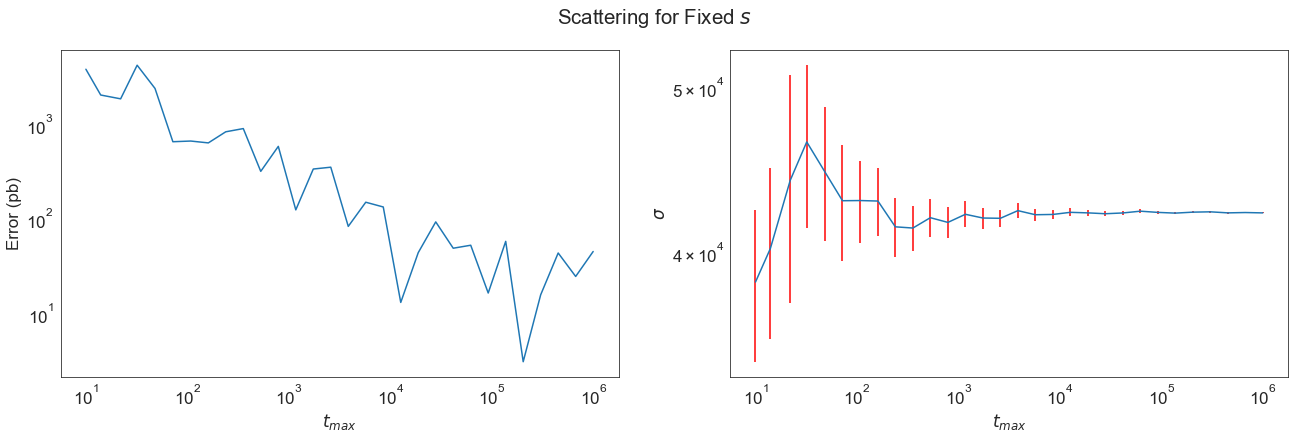

In [6]:
plt.figure(figsize=(22,6))
plt.tight_layout()
plt.suptitle('Scattering for Fixed $s$')

plt.subplot(1,2,1)
plt.loglog(N_list, error_list)
plt.xlabel('$t_{max}$')
plt.ylabel('Error (pb)')

plt.subplot(1,2,2)
plt.errorbar(N_list, sigma_list, yerr=uncertainty_list,ecolor='red')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$t_{max}$')
plt.ylabel('$\sigma$')
plt.savefig('figures/montecarlo_fixed_s.png')


## b)  s from uniform distribution

In [7]:
benchmark_value = 9880
N_montecarlo = 5*10**5

sigma_eval_0, sigma_res, montecarlo_uncertainty, error,s_0 = \
                          montecarlo_cross_section(N_montecarlo, benchmark_value, s0 ,constant_s=False )

print('value = ', sigma_res, '+ - ', montecarlo_uncertainty, 'pb')
print('true = ', benchmark_value, 'pb')
print('error = ', np.abs(sigma_res-benchmark_value), 'pb')


value =  9941.314416102547 + -  35.41218955313479 pb
true =  9880 pb
error =  61.3144161025466 pb


In [8]:
# comparisson with the constant s case
s_array = np.linspace((Mz - 3*Gammaz)**2 ,(Mz + 3*Gammaz)**2, num=40)
sigma_s = []

for s0 in s_array:
    _, sigma_res, _, _,_ = \
                          montecarlo_cross_section(N_montecarlo, benchmark_value, s0 ,constant_s=True )
    sigma_s.append(sigma_res)
    
sigma_s = np.asarray(sigma_s)

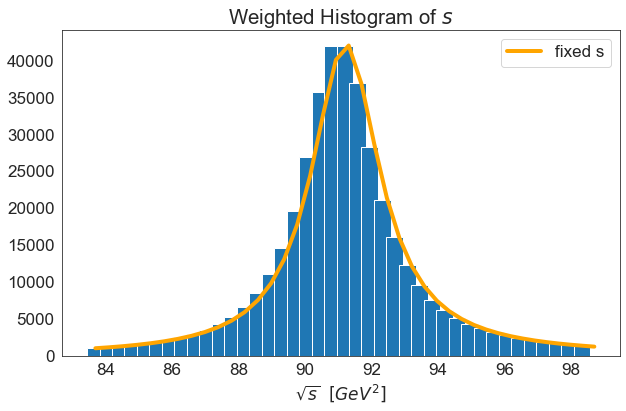

In [9]:
f_s = 1.0/((Mz + 3*Gammaz)**2-(Mz - 3*Gammaz)**2)

hist, bin_edges = np.histogram(np.sqrt(s_0), weights=sigma_eval_0, bins=40)
hist = (hist*1/f_s)*20*10**5

plt.figure(figsize=(10,6))
plt.title('Weighted Histogram of $s$')
plt.bar(bin_edges[:-1], hist, width = 0.5)
plt.plot(np.sqrt(s_array),sigma_s, color='orange', linewidth=4, label='fixed s')
plt.xlabel("$\sqrt{s} \;\; [GeV^2]$")
plt.legend()

plt.savefig('figures/s_histogram.png')

In [10]:
# calculate the cross section for several max montecarlo points
N_list = np.logspace(1, 6,30).astype(int)

sigma_list = []
uncertainty_list = []
error_list = []

for n in N_list:
    sigma_eval, sigma_res, montecarlo_uncertainty, error,s = montecarlo_cross_section(n, benchmark_value, 
                                                                                    s0, constant_s=False)
    sigma_list.append(sigma_res)
    uncertainty_list.append(montecarlo_uncertainty)
    error_list.append(error)
    

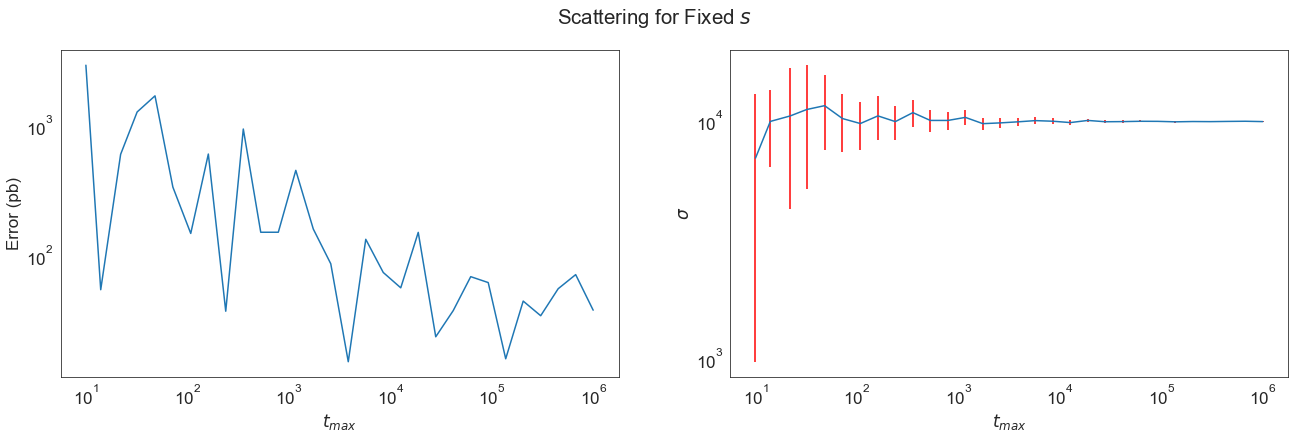

In [11]:
plt.figure(figsize=(22,6))
plt.tight_layout()
plt.suptitle('Scattering for Fixed $s$')

plt.subplot(1,2,1)
plt.loglog(N_list, error_list)
plt.xlabel('$t_{max}$')
plt.ylabel('Error (pb)')

plt.subplot(1,2,2)
plt.errorbar(N_list, sigma_list, yerr=uncertainty_list,ecolor='red')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$t_{max}$')
plt.ylabel('$\sigma$')
plt.savefig('figures/montecarlo_uniform_s.png')

## Vegas Integration

In [12]:
# we have to redifine the cross section to work for vegas
def diff_cross_section_vegas(fs, x):
    # differential cross section for vegas
    # args-> x:, array, represents a point in the integration volume x[0]=s , x[1]=cos(\theta)
    # returns-> array: the differential cross section evaluated on the given points
    
    # integral factors
    phi_ = 2*np.pi
    
    # randomly choose quark flavors
    flavor_index = np.random.randint(low=0,high=Nq)
    # calculate the values for each step
    Qq = quark_charges[flavor_index]
    isospin = quark_isospin[flavor_index]
    Aq = Af(isospin)
    Vq = Vf(isospin, Qq)
        
    sigma_vegas = (fs/(x[0]*64.0*np.pi**2)) * ( (4*np.pi*alpha)**2*Nc*( (1+x[1]**2)*(Qe**2*Qq**2 \
                   + 2*Qe*Qq*Ve*Vq*Chi1(x[0]) + (Ae**2+Ve**2)*(Aq**2 + Vq**2)*Chi2(x[0]))\
                   + x[1]*( 4*Qe*Qq*Ae*Aq*Chi1(x[0]) + 8*Ae*Ve*Aq*Vq*Chi2(x[0]) ) ) )
    
    return  Nq*phi_*(sigma_vegas)*F_conv


In [13]:
N_montecarlo = 1000

# choose s as an uniformly distributed variable
s_upper = (Mz + 3*Gammaz)**2 
s_lower = (Mz - 3*Gammaz)**2 
f_vegas = 1.0/(s_upper-s_lower)


# first interval is for s, second is for cos(\theta)
integrator = vegas.Integrator([ [s_lower, s_upper], [-1,1] ])

cross_section_vegas = integrator(functools.partial(diff_cross_section_vegas,f_vegas), nitn = 10, neval = N_montecarlo)

cross_section_vegas.summary()


'itn   integral        wgt average     chi2/dof        Q\n-------------------------------------------------------\n  1   10023(128)      10023(128)          0.00     1.00\n  2   10017(71)       10019(62)           0.00     0.97\n  3   9910(55)        9958(41)            0.85     0.43\n  4   10004(51)       9977(32)            0.73     0.53\n  5   9930(48)        9962(27)            0.71     0.58\n  6   9963(46)        9962(23)            0.57     0.72\n  7   10020(44)       9975(20)            0.70     0.65\n  8   9963(45)        9973(19)            0.61     0.75\n  9   9908(42)        9962(17)            0.78     0.62\n 10   9914(42)        9955(16)            0.82     0.60\n'

benchmark value =  9880


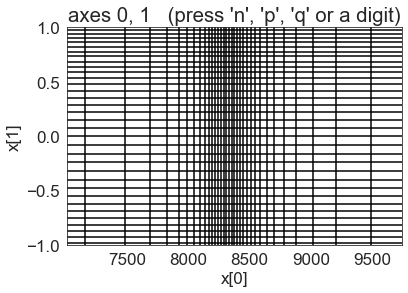

<Figure size 432x288 with 0 Axes>

In [14]:
print('benchmark value = ' , 9880 )

integrator.map.show_grid(30)
plt.savefig('figures/vegas_fig.png')

## Importance Sampling

Using the breit-wigner distribution


In [15]:
def breit_wigner(s_var):
    return 1/((s_var-Mz**2)**2 + Mz**2*Gammaz**2)

def pick_s_from_rho(rho_var):
    return np.tan(rho_var)* Mz*Gammaz + Mz**2

def calcualte_rho(s_var):
    return np.arctan((s_var - Mz**2)/(Mz*Gammaz))

def init_importance_sampling(N_steps):
    # generate the events for the importance sampling
    
    # randomly generate the indices  
    charge_sequence, Aq_array, Vq_array = initialize_quark_sequence(N_steps)
    
    s_upper = (Mz + 3*Gammaz)**2 
    s_lower = (Mz - 3*Gammaz)**2 
    # generate the simulation events

    # get the upper and lower indices
    rho_lower = calcualte_rho(s_lower)
    rho_upper = calcualte_rho(s_upper)
    
    volume_interval =  2* (rho_upper - rho_lower)/(Mz*Gammaz)
    
    # generate random rho's
    rho_rand = np.random.uniform(low=rho_lower, high=rho_upper, size=(N_steps))
    # calculate s from rho
    s_var = pick_s_from_rho(rho_rand)
    fs = 1.0/(s_upper-s_lower)
    
    # generate angles
    costh = np.random.uniform(low=-1, high=1, size=(N_steps))
    phi = np.random.uniform(low=0, high=2*np.pi, size=(N_steps))
    
    return s_var, fs, costh, phi, Aq_array, Vq_array, charge_sequence, volume_interval


In [16]:
N_montecarlo = 10**4
benchmark_value = 9880

s, fs, costh, phi, Aq_array, Vq_array, charge_sequence, \
                 volume_interval = init_importance_sampling(N_montecarlo)

# breit wigner function
bf_function = breit_wigner(s)

# calculate sigma
sigma_eval = diff_cross_section(s, costh, fs, charge_sequence ,Aq_array, Vq_array)

phi_integral = 2*np.pi

importance_sigma = Nq*phi_integral*volume_interval*(np.mean(sigma_eval/bf_function))*F_conv
importance_uncert =  volume_interval*Nq*phi_integral*F_conv*np.sqrt((np.mean((sigma_eval/bf_function)**2) - 
                                                                    np.mean(sigma_eval/bf_function)**2)/N_montecarlo)

print('calculated cross section = ', importance_sigma,'+-',importance_uncert)
print('true = ', benchmark_value, 'pb')
print('error = ', np.abs(importance_sigma-benchmark_value), 'pb')


calculated cross section =  9923.60061117063 +- 31.580741630191838
true =  9880 pb
error =  43.600611170630145 pb


In [17]:
# calculate the cross section for several max montecarlo points
N_list = np.logspace(1, 6,30).astype(int)

sigma_list = []
uncertainty_list = []
error_list = []

for n in N_list:
    s, fs, costh, phi, Aq_array, Vq_array, charge_sequence, \
                 volume_interval = init_importance_sampling(n)

    # breit wigner function
    bf_function = breit_wigner(s)

    # calculate sigma
    sigma_eval = diff_cross_section(s, costh, fs, charge_sequence ,Aq_array, Vq_array)

    phi_integral = 2*np.pi

    importance_sigma = Nq*phi_integral*volume_interval*(np.mean(sigma_eval/bf_function))*F_conv
    importance_uncert =  volume_interval*Nq*phi_integral*F_conv*np.sqrt((np.mean((sigma_eval/bf_function)**2) - 
                                                                        np.mean(sigma_eval/bf_function)**2)/n)
    error = np.abs(importance_sigma-benchmark_value)
    
    sigma_list.append(importance_sigma)
    uncertainty_list.append(importance_uncert)
    error_list.append(error)
    

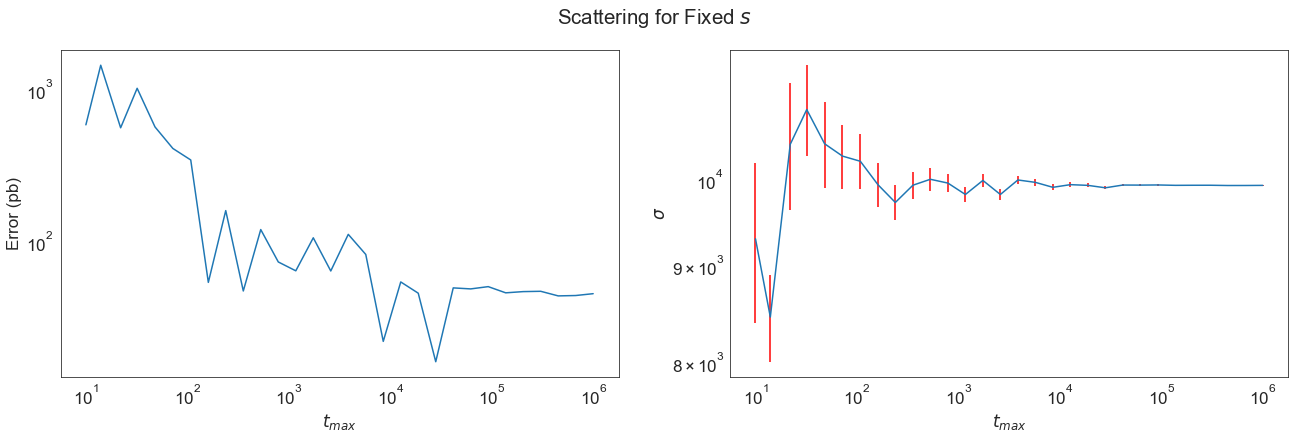

In [18]:
plt.figure(figsize=(22,6))
plt.tight_layout()
plt.suptitle('Scattering for Fixed $s$')

plt.subplot(1,2,1)
plt.loglog(N_list, error_list)
plt.xlabel('$t_{max}$')
plt.ylabel('Error (pb)')

plt.subplot(1,2,2)
plt.errorbar(N_list, sigma_list, yerr=uncertainty_list,ecolor='red')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$t_{max}$')
plt.ylabel('$\sigma$')
plt.savefig('figures/montecarlo_importance_sampling.png')


# Parton shower

In [19]:
# get the coupling for several values of momentum
ts_array = np.logspace(0, 5,100).astype(int)
alpha_s = alphas.AlphaS(Mz, Alpha_mz)

coupling0_array = np.asarray([alpha_s.as0(t) for t in ts_array])
coupling1_array = np.asarray([alpha_s.as1(t) for t in ts_array])

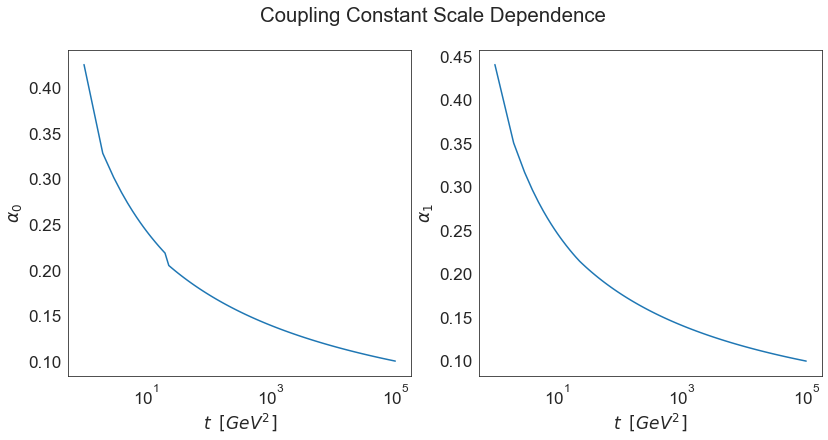

In [20]:
plt.figure(figsize=(13.5,6))
plt.suptitle('Coupling Constant Scale Dependence')
plt.tight_layout()
plt.subplot(1,2,1)
plt.plot(ts_array,coupling0_array)
plt.xscale('log')
plt.ylabel(r"$\alpha_0$")
plt.xlabel(r"$t \;\; [GeV^2]$")

plt.subplot(1,2,2)
plt.plot(ts_array,coupling1_array)
plt.xscale('log')
plt.ylabel(r"$\alpha_1$")
plt.xlabel(r"$t \;\; [GeV^2]$")
plt.savefig('figures/coupling_as_t.png')



In [40]:

N_montecarlo = 1000
# initialize the events
s, fs, costh, phi, Aq_array, Vq_array, charge_sequence, \
                 volume_interval = init_importance_sampling(N_montecarlo)
# breit wigner function
bf_function = breit_wigner(s)

# calculate sigma
sigma_eval = diff_cross_section(s, costh, fs, charge_sequence ,Aq_array, Vq_array)
phi_integral = 2*np.pi
differential_sigma = Nq*phi_integral*volume_interval*(sigma_eval/bf_function)*F_conv


In [41]:
# factor for the initial momenta
pref = np.sqrt(s)/2.0

# scattering angles
theta = np.arccos(costh)

# iterate on events 
p_eplus_list = []
p_minus_list = []
p_q_list = []
p_barq_list = []
event_list = []

# iterate over all montecarlo events to create the objects
for i in range(0, N_montecarlo):

    # momenta for incoming particles
    p_eplus = vector.Vec4(pref[i], 0,0,pref[i])
    p_eminus = vector.Vec4(pref[i], 0,0,-pref[i])

    # momenta for outgoing particles
    p_q = vector.Vec4(pref[i], -pref[i]*np.cos(phi[i])*np.sin(theta[i]), -pref[i]*np.sin(phi[i])*np.sin(theta[i]),
                      -pref[i]*np.cos(theta[i]))
    
    p_barq = vector.Vec4(pref[i], pref[i]*np.cos(phi[i])*np.sin(theta[i]), pref[i]*np.sin(phi[i])*np.sin(theta[i]),
                         pref[i]*np.cos(theta[i]))
    
    # save momenta
    #p_eplus_list.append(p_eplus)
    #p_minus_list.append(p_eminus)
    #p_q_list.append(p_q)
    #p_barq_list.append(p_barq)

    # prepare the arguments for the shower class 
    # incoming particles 
    c_e = particle.Particle(E_, p_eminus, [0,0])
    c_antie = particle.Particle(E_, p_eplus, [0,0])
    
    # find flavor of the outgoing quark: since there are repeated charges there are several possibilities each time
    possible_quark = np.argwhere(quark_charges==charge_sequence[i]).reshape(-1,)
    quark_index = np.random.choice(possible_quark)
    quark_id = quark_pdgids[quark_index]
    
    # outgoing particles
    c_quark = particle.Particle(quark_id, p_q, [1,0])
    c_antiquark = particle.Particle(quark_id, p_barq, [0,1])

    gen_event = [c_e, c_antie, c_quark, c_antiquark]
    # specify the scale of the ecent
    t_scale = Mz**2
    showers = shower.Shower(alpha_s)
    # run the shower
    showers.Run(gen_event,t_scale)
    # save the generated shower for each step
    event_list.append(gen_event)


In [46]:
# count the final state particles, the first 2 positions are always the initial state electron and anti-e
particle_count = [len(x[2:]) for x in event_list]
av_particle_count = np.sum(np.asarray(particle_count) * np.asarray(differential_sigma))/np.sum(differential_sigma)


Average Particle Count:  4.415969156039356
mean of the weights:  9852.385581422099


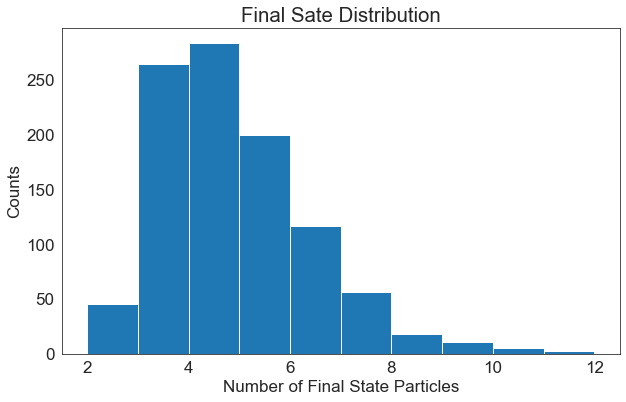

In [52]:
print('Average Particle Count: ', av_particle_count)
print('mean of the weights: ' , np.mean(differential_sigma))

plt.figure(figsize=(10,6))
plt.title('Final Sate Distribution')
plt.hist(particle_count);
plt.xlabel('Number of Final State Particles')
plt.ylabel('Counts')
plt.savefig('figures/final_state_hist.png')


to create a particle I need both the id and the colour charge
https://pdg.lbl.gov/2019/reviews/rpp2019-rev-monte-carlo-numbering.pdf

Remember that we are ALWAYS creating a quark anti quark pair, so at each step of the way, the properties are the same exept for the charges (electric, color or whatever) are the negative

# Jet Formation